These are two types of ANN layer, deisgned to handle SparseTensor input.

In [1]:
import torch
from torch import optim
import numpy as np
import scipy as sp
import scipy.sparse as spr
import scipy.linalg as la
from scipy.spatial.distance import cdist
from lapsolver import solve_dense
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
import networkx as nx

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [3]:
class SparseLinear(torch.nn.Linear):
    def __init__(self, *params):
        super(SparseLinear, self).__init__(*params)
    
    def forward(self,x):
        return torch.sparse_coo_tensor(
        x._indices(),
        super().forward(x._values())
    )   

class SparseActivation(torch.nn.Module):
    def __init__(self, act):
        super(SparseActivation, self).__init__()
        self.act = act
        
    def forward(self,x):
        return torch.sparse_coo_tensor(
        x._indices(),
        self.act(x._values())
    )

Loading the filenames, which will be used to load the dataset:

In [4]:
DATASET = 'morpho'

if DATASET == 'morpho':
    GR_SIZE = (64,64,3)
    fnames = open("morpho_filenames.txt",'r').read().split()
    fnames = list(filter(lambda x:'r' in x.split("/")[-1],fnames))
    fnames = sorted(fnames)
    main_directory = "graphs"

In [5]:
def fname_to_matrix(fn):
    raw = np.loadtxt(main_directory+"/" + fn + "_ed.csv").astype('float')
    return raw

def fname_to_vertdata(fn):
    raw = np.loadtxt(main_directory+"/" + fn + "_ve.csv").astype('float')
    return raw

In [6]:
torch.cuda.is_available()

True

In [7]:
adj = [fname_to_matrix(fnames[i])[:,] for i in range(len(fnames))]

def filename_to_label(fname):
    if "WT" in fname:
        return "wt"
    elif "trm" in fname:
        return "trm"
    else:
        return "_".join(fname.split("/")[1].split('_')[:-2])

labels = [filename_to_label(fnames[i]) for i in range(len(fnames))]

In [8]:
unique_labels = sorted(list(set(labels)))
label_indices = {unique_labels[i]:i for i in range(len(unique_labels))}
labels = [label_indices[item] for item in labels]
label_tensor = torch.tensor(np.array(labels))

In [9]:
label_indices

{'s0_s0_s0_s0': 0,
 's0_s0_s0_s1': 1,
 's0_s0_s0_s2': 2,
 's0_s0_s0_s3': 3,
 's0_s0_s0_s4': 4,
 's0_s0_s0_s5': 5,
 's0_s0_s1_s0': 6,
 's0_s0_s1_s1': 7,
 's0_s0_s1_s2': 8,
 's0_s0_s1_s3': 9,
 's0_s0_s1_s4': 10,
 's0_s0_s1_s5': 11,
 's0_s0_s2_s0': 12,
 's0_s0_s2_s1': 13,
 's0_s0_s2_s2': 14,
 's0_s0_s2_s3': 15,
 's0_s0_s2_s4': 16,
 's0_s0_s2_s5': 17,
 's0_s0_s3_s0': 18,
 's0_s0_s3_s1': 19,
 's0_s0_s3_s2': 20,
 's0_s0_s3_s3': 21,
 's0_s0_s3_s4': 22,
 's0_s0_s3_s5': 23,
 's0_s1_s0_s0': 24,
 's0_s1_s0_s1': 25,
 's0_s1_s0_s2': 26,
 's0_s1_s0_s3': 27,
 's0_s1_s0_s4': 28,
 's0_s1_s0_s5': 29,
 's0_s1_s1_s0': 30,
 's0_s1_s1_s1': 31,
 's0_s1_s1_s2': 32,
 's0_s1_s1_s3': 33,
 's0_s1_s1_s4': 34,
 's0_s1_s1_s5': 35,
 's0_s1_s2_s0': 36,
 's0_s1_s2_s1': 37,
 's0_s1_s2_s2': 38,
 's0_s1_s2_s3': 39,
 's0_s1_s2_s4': 40,
 's0_s1_s2_s5': 41,
 's0_s1_s3_s0': 42,
 's0_s1_s3_s1': 43,
 's0_s1_s3_s2': 44,
 's0_s1_s3_s3': 45,
 's0_s1_s3_s4': 46,
 's0_s1_s3_s5': 47,
 's0_s2_s0_s0': 48,
 's0_s2_s0_s1': 49,
 's0_s2_s0

In [10]:
TRM_IDX = label_indices['trm']
WID_IDX = label_indices['wt']

In [11]:
all_idxs = np.arange(len(adj))
label_arr = np.array(labels)

valid_idx_list = []
train_idx_list = []
sim_idx_list = []

for ll in list(set(labels)):
    subL = all_idxs[label_arr == ll].copy()
    if ll == TRM_IDX or ll == WID_IDX:
        np.random.shuffle(subL)
        split = int(.85*len(subL))
        train_idx_list.append(subL[:split])
        valid_idx_list.append(subL[split:])
    else:
        sim_idx_list.append(subL)
        
train_idxs = np.concatenate(train_idx_list)
valid_idxs = np.concatenate(valid_idx_list)
sim_idxs = np.concatenate(sim_idx_list)

In [12]:
full = np.concatenate(adj)[train_idxs,2:]
full_mn = np.min(full, axis=0,keepdims=True)
full_std = np.max(full, axis=0,keepdims=True) - full_mn

In [13]:
for i in range(len(adj)):
    pass
    #adj[i][:,2:] -= full_mn
    #adj[i][:,2:] /= full_std
    #adj[i][:,2:] += 1.0
adj_sparse = [
    torch.sparse_coo_tensor(
        [adj[i][:,0].astype('int'),adj[i][:,1].astype('int')],
        adj[i][:,2:].astype('double'),
        GR_SIZE
    )
    for i in range(len(adj))
]

In [14]:
adj_sparse[0]._values()[0]

tensor([  0.7918,  40.1550, 111.0000], dtype=torch.float64)

In [15]:
len(adj_sparse)

27507

Experiment 1: Baseline performance of GDD, with no optimization of t or other weight parameters.

In [16]:
if DATASET == "morpho":
    aa1 = torch.stack(adj_sparse).to_dense()[:,:,:,-1]

In [17]:
aa1.max()

tensor(690., dtype=torch.float64)

In [18]:
aa1.shape

torch.Size([27507, 64, 64])

tp is the list of t values to try. 

In [19]:

if DATASET == 'morpho':
    sigma = 1/aa1.max()
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-3,3,128))))
    new_weights = torch.ones(64).cuda()
else:
    sigma = .1
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-3,3,64))))

In [20]:
expt1_dmat = np.zeros((aa1.shape[0],aa1.shape[0]))

In [21]:
index_batches = np.array_split(np.arange(len(adj)),30)

In [22]:
def laplModelForward(aa1small):
    aa1small = aa1small.to_dense()[:,:,:,-1]
    all_adj = torch.sign(aa1small) #* torch.exp(-.5*torch.pow(aa1small,2.0)*sigma)
    #print(all_adj.shape)
    #print(all_adj.shape)
    all_adj = all_adj
    
    dd = torch.abs(all_adj)
    dd = .5*(dd + torch.transpose(dd,-1,-2))
    dsum = dd.sum(-1)
    
    final_mm = all_adj - torch.diag_embed(dsum)
    return final_mm

def eigenModelForward(batchA):
    final_mm = laplModelForward(batchA)
    raw_eigs = torch.symeig(final_mm,eigenvectors=True)[0].clone()
    return raw_eigs
    #eigex = torch.exp(tt*raw_eigs)*new_weights
    #return eigex

In [23]:
K = len(unique_labels)
new_dm_table = np.zeros((K,K))

subarrs = [expt1_dmat[label_arr==i,:] for i in range(K)]
subarrs = [[subarrs[i][:,label_arr==j]for j in range(K)] for i in range(K)]

for i in range(K):
    for j in range(K):
        new_dm_table[i,j] = subarrs[i][j].mean()

In [24]:
with torch.no_grad():
    efts = torch.cat(
        [eigenModelForward(torch.stack([adj_sparse[i] for i in  index_batches[i1]]).float().cuda()).cpu()
         for i1 in range(len(index_batches))]
    ) 

    for i1 in range(len(index_batches)):
        print(i1)
        for i2 in range(i1,len(index_batches)):
            idxs1 = index_batches[i1]
            idxs2 = index_batches[i2]
            fts1 = efts[idxs1,:].cuda()#eigenModelrForward(torch.stack([adj_sparse[i] for i in idxs1]).float().cuda())
            fts2 = efts[idxs2,:].cuda()#eigenModelForward(torch.stack([adj_sparse[i] for i in idxs2]).float().cuda())

            dmats = []
            for tidx in range(tp.shape[0]):
                eee1pr = torch.exp(fts1*torch.abs(tp[tidx]))*new_weights
                eee2pr = torch.exp(fts2*torch.abs(tp[tidx]))*new_weights
                dmat = torch.cdist(eee1pr,eee2pr)
                dmats.append(dmat)

            expt1_dmat[np.ix_(idxs1, idxs2)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy()
            expt1_dmat[np.ix_(idxs2, idxs1)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy().T        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [27]:
del efts

In [28]:
validation_results = []
for kk in range(3,50):
    classifier = KNeighborsClassifier(kk,metric='precomputed',weights='distance')
    classifier.fit(expt1_dmat[np.ix_(train_idxs, train_idxs)],np.array(labels)[train_idxs])
    class_preds = classifier.predict(expt1_dmat[np.ix_(valid_idxs, train_idxs)])
    acc_array = class_preds == np.array(labels)[valid_idxs]
    validation_results.append((kk, np.mean(acc_array)))
    
expt1_validation_results = validation_results    

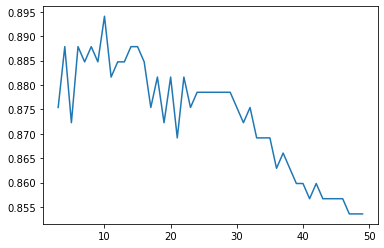

In [29]:
%matplotlib inline
plt.plot(*np.array(expt1_validation_results).T)

In [30]:
scores_by_K = np.array(validation_results)
best_K = int(scores_by_K[np.argsort(scores_by_K[:,1])][-1,0])

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap

In [32]:
def dist_mat_plot(dist_mat, tidxs, vidxs):
    fig = plt.figure(figsize=(10,10))
    all_plot_idxs = np.concatenate([tidxs,vidxs])
    all_plot_idxs = all_plot_idxs[np.argsort(label_arr[all_plot_idxs])]
    ax = plt.gca()
    ax.matshow(dist_mat[np.ix_(all_plot_idxs, all_plot_idxs)])
    ax.axis('off')
    fig.show()
    
def mds_plot(embedder, THE_DMAT, tidxs, vidxs):
    fig = plt.figure(figsize=(10,10))
    all_plot_idxs = np.concatenate([tidxs,vidxs])
    all_plot_idxs = all_plot_idxs[np.argsort(label_arr[all_plot_idxs])]
    
    valid_labels = label_arr[vidxs]
    train_labels = label_arr[tidxs]
    
    Xtrain= embedder.fit_transform(
        THE_DMAT[np.ix_(tidxs, tidxs)]
    )
    Xvalid= embedder.transform(
        THE_DMAT[np.ix_(vidxs, tidxs)]
    )
    
    ax = fig.gca()
    ax.scatter(*Xtrain[train_labels == WID_IDX ].T, c= 'C0', alpha=.225)
    ax.scatter(*Xtrain[train_labels == TRM_IDX ].T, c= 'C1', alpha=.225)
    
    ax.scatter(*Xvalid[valid_labels == WID_IDX ].T, c= 'C0', alpha=1.0)
    ax.scatter(*Xvalid[valid_labels == TRM_IDX ].T, c= 'C1', alpha=1.0)
    
    #plt.scatter(Xtrain)
    
    fig.show()    

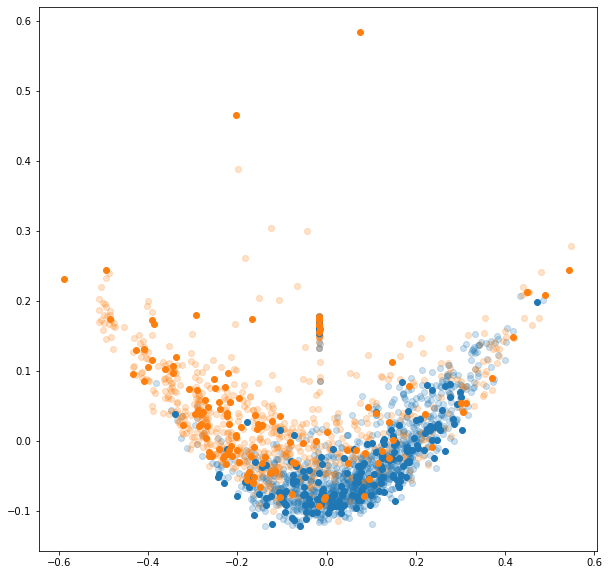

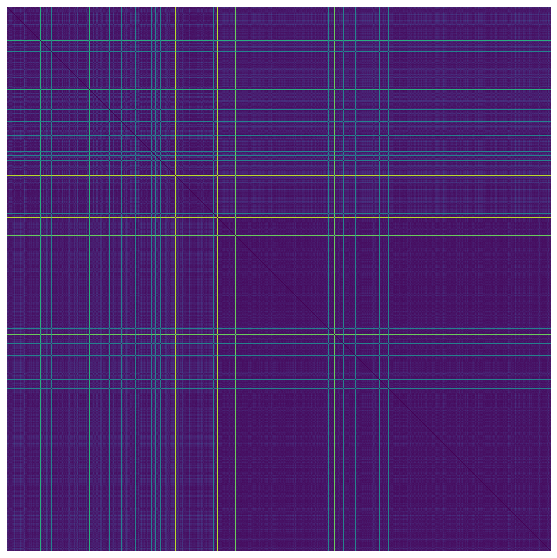

In [33]:
embedder = Isomap(n_neighbors=10, n_components=2,metric='precomputed')
mds_plot(embedder, expt1_dmat, train_idxs, valid_idxs)
dist_mat_plot(expt1_dmat, train_idxs, valid_idxs)

In [34]:
del expt1_dmat

Experiment 2:

Reweighting the eigenvalues using a vector of weights, of the same length.

Additionally, tuning the parameters t and sigmausing backprop through the eigenvalue computation.

In order to do this, we need a loss function. We'll use contrastive loss.

In [35]:
if DATASET == 'morpho':
    sigma = torch.nn.Parameter(.0001/aa1.max())
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-2,2,16))))
else:
    sigma = .01
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-3,3,8))))

eweights = torch.ones(GR_SIZE[0])
optimizer = optim.Adam([sigma,tp,eweights], lr=0.01)



In [36]:
def laplModelForward(aa1small):
    all_adj = torch.sign(aa1small) #* torch.exp(-.5*torch.pow(aa1small,2.0)*sigma)
    #print(all_adj.shape)
    #print(all_adj.shape)
    all_adj = all_adj
    
    dd = torch.abs(all_adj)
    dd = .5*(dd + torch.transpose(dd,-1,-2))
    dsum = dd.sum(-1)
    
    final_mm = all_adj - torch.diag_embed(dsum)
    return final_mm

def eigenModelForward(batchA):
    final_mm = laplModelForward(batchA)
    raw_eigs = torch.symeig(final_mm,eigenvectors=True)[0].clone()
    return raw_eigs
    #eigex = torch.exp(tt*raw_eigs)*new_weights
    #return eigex

In [37]:
train_dataset = TensorDataset( torch.stack([aa1[i] for i in train_idxs]), label_tensor[train_idxs] )
train_loader = DataLoader(train_dataset, shuffle=True,batch_size= 256,drop_last=False)

valid_dataset = TensorDataset( torch.stack([aa1[i] for i in valid_idxs]), label_tensor[valid_idxs] )
valid_loader = DataLoader(valid_dataset, shuffle=False,batch_size= 32)

In [38]:
(np.max(np.diag(new_dm_table)),
np.min(new_dm_table + 1e12*np.eye(len(unique_labels))))

(0.0, 0.0)

For contrastive loss, we need upper and lower margins.

We'll establish these so that the lower margin is less than, but close to, the smallest within-category distance from Experiment 1. The upper margin will be more than, but close to, the biggest 

In [39]:
if DATASET == 'morpho':
    upper_margin = .33
    lower_margin = 0.001
else:
    lower_margin = .5
    upper_margin = 1.33

We can get an idea of whether the learing process is going well by comparing contrastive loss with these values to contrastive loss on the original distance matrix.

In [40]:
all_labels = np.array(labels)[train_idxs].reshape(-1,1)
dist_mat_label = torch.Tensor(np.sign(cdist(all_labels, all_labels)))
dist_mat_batch = torch.Tensor(expt1_dmat[np.ix_(train_idxs,train_idxs)])
loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
loss = torch.pow(loss_full,2.0).mean()
print(loss)

NameError: name 'expt1_dmat' is not defined

In [42]:
torch.__version__

'1.8.0'

In [43]:
tp

Parameter containing:
tensor([0.1353, 0.1767, 0.2307, 0.3012, 0.3932, 0.5134, 0.6703, 0.8752, 1.1426,
        1.4918, 1.9477, 2.5430, 3.3201, 4.3348, 5.6595, 7.3891],
       requires_grad=True)

In [44]:
for k in range(200):
    total_loss = 0
    total_used = 0
    for ii, batch in enumerate(train_loader):
        optimizer.zero_grad()
        batchA, batchL = batch
        #print(batchA)
        batchT = batchA.float().cuda()
        batchTL = batchL.float().cuda()
        ft = eigenModelForward(batchT)
        
        
        tt = torch.abs(tp).cuda()
        new_weights = (GR_SIZE[0]*torch.nn.functional.softmax(eweights,dim=0).reshape(1,GR_SIZE[0])).cuda()
        
        dmats = []
        for tidx in range(tp.shape[0]):
            eee1pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            eee2pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            dmat = torch.cdist(eee1pr,eee2pr)
            dmats.append(dmat)
            
        dist_mat_batch = torch.stack(dmats).max(0)[0]
        dist_mat_label = torch.sign(torch.cdist(batchTL.unsqueeze(-1),batchTL.unsqueeze(-1)))
        
        #print(dist_mat_batch)
        loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
        #print(loss_full)
        loss = torch.pow(loss_full,2.0).sum()
        #print(loss_full.max())
        total_loss += loss.detach()
        used_batch = batch[0].shape[0]
        total_used += used_batch * used_batch
        #print(used_batch)
        loss = loss * (1.0/used_batch) * (1.0/used_batch)  
        loss.backward()
        optimizer.step()
      
    print(k, (total_loss/total_used).detach().cpu().numpy())

0 0.08145455
1 0.08068481
2 0.07977679
3 0.0795582
4 0.07664339
5 0.079338655
6 0.07819387
7 0.07783182
8 0.078244895
9 0.07786717
10 0.077095486
11 0.07690342
12 0.076850854
13 0.07578086
14 0.07727337
15 0.07610507
16 0.07579123
17 0.0754192
18 0.074772745
19 0.07463395
20 0.07477487
21 0.074333526
22 0.072886944
23 0.07220758
24 0.07325942
25 0.07128969
26 0.072022565
27 0.07188796


KeyboardInterrupt: 

In [ ]:
tp, eweights

In [45]:
expt2_dmat = np.zeros((aa1.shape[0],aa1.shape[0]))

In [46]:
with torch.no_grad():
    efts = torch.cat(
        [eigenModelForward(torch.stack([aa1[i] for i in  index_batches[i1]]).float().cuda()).cpu()
         for i1 in range(len(index_batches))]
    ) 

    for i1 in range(len(index_batches)):
        print(i1)
        for i2 in range(i1,len(index_batches)):
            idxs1 = index_batches[i1]
            idxs2 = index_batches[i2]
            fts1 = efts[idxs1,:].cuda()#eigenModelrForward(torch.stack([adj_sparse[i] for i in idxs1]).float().cuda())
            fts2 = efts[idxs2,:].cuda()#eigenModelForward(torch.stack([adj_sparse[i] for i in idxs2]).float().cuda())

            dmats = []
            for tidx in range(tp.shape[0]):
                eee1pr = torch.exp(fts1*torch.abs(tp[tidx]))*new_weights
                eee2pr = torch.exp(fts2*torch.abs(tp[tidx]))*new_weights
                dmat = torch.cdist(eee1pr,eee2pr)
                dmats.append(dmat)

            expt2_dmat[np.ix_(idxs1, idxs2)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy()
            expt2_dmat[np.ix_(idxs2, idxs1)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy().T        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [47]:
K = len(unique_labels)
new_dm_table = np.zeros((K,K))

subarrs = [expt2_dmat[label_arr==i,:] for i in range(K)]
subarrs = [[subarrs[i][:,label_arr==j]for j in range(K)] for i in range(K)]

for i in range(K):
    for j in range(K):
        new_dm_table[i,j] = subarrs[i][j].mean()

In [50]:
validation_results = []
for kk in range(3,50):
    classifier = KNeighborsClassifier(kk,metric='precomputed',weights='distance')
    classifier.fit(expt2_dmat[np.ix_(train_idxs, train_idxs)],np.array(labels)[train_idxs])
    class_preds = classifier.predict(expt2_dmat[np.ix_(valid_idxs, train_idxs)])
    acc_array = class_preds == np.array(labels)[valid_idxs]
    validation_results.append((kk, np.mean(acc_array)))
    
expt2_validation_results = validation_results    

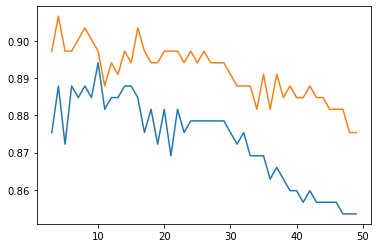

In [51]:
%matplotlib inline
plt.plot(*np.array(expt1_validation_results).T)
plt.plot(*np.array(expt2_validation_results).T)

In [52]:
scores_by_K = np.array(expt2_validation_results)
best_K = int(scores_by_K[np.argsort(scores_by_K[:,1])][-1,0])

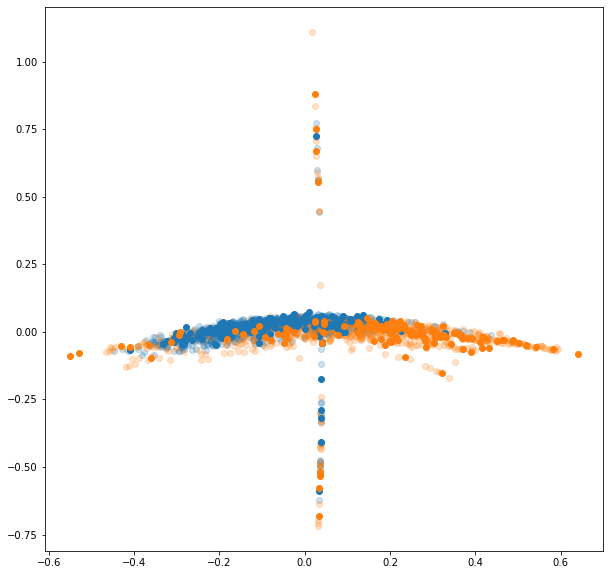

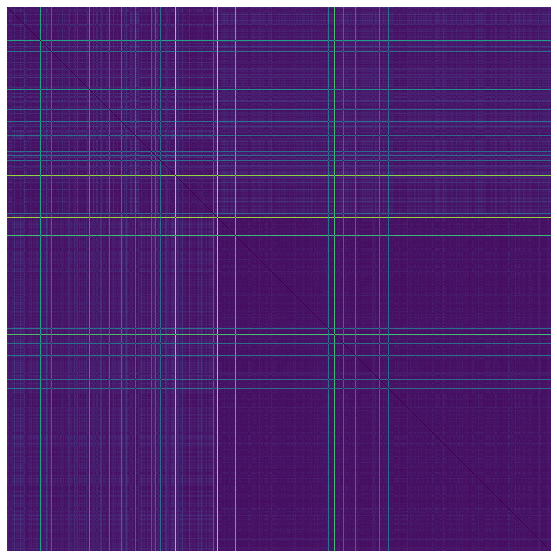

In [55]:
embedder = Isomap(n_neighbors=best_K, n_components=2,metric='precomputed')
mds_plot(embedder, expt2_dmat, train_idxs, valid_idxs)
dist_mat_plot(expt2_dmat, train_idxs, valid_idxs)

In [54]:
del efts

In [56]:
del expt2_dmat

Experiment 3:

Reweighting the eigenvalues using a vector of weights, of the same length.

Additionally, tuning the parameter t using backprop through the eigenvalue computation.

Additionally, tuning a 'distance' parameter sigma.

In order to do this, we need a loss function. We'll use contrastive loss.

In [87]:
if DATASET == 'morpho':
    sigma1 = torch.nn.Parameter(torch.Tensor([.01]))
    sigma2 = torch.nn.Parameter(torch.Tensor([1.0/120.00]))
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-2,2,16))))
else:
    sigma = .01
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-3,3,8))))

eweights = torch.nn.Parameter(torch.ones(GR_SIZE[0]))
optimizer = optim.Adam([sigma1,sigma2,tp,eweights], lr=0.01)



In [102]:
def laplModelForward(aa1small):
    part1 = aa1small.to_dense()[:,:,:,-2]
    part2 = aa1small.to_dense()[:,:,:,-1]
    all_adj = torch.sign(part1) * (part2*torch.abs(sigma2.cuda())) * torch.exp(-.5*torch.pow(part1,2.0)*torch.abs(sigma1.cuda()))
    #print(aa1small.max())
    #print(all_adj.shape)
    #print(all_adj.shape)
    all_adj = all_adj
    
    dd = torch.abs(all_adj)
    dd = .5*(dd + torch.transpose(dd,-1,-2))
    dsum = dd.sum(-1)
    
    final_mm = all_adj - torch.diag_embed(dsum)
    return final_mm

def eigenModelForward(batchA):
    final_mm = laplModelForward(batchA)
    raw_eigs = torch.symeig(final_mm,eigenvectors=True)[0].clone()
    return raw_eigs
    #eigex = torch.exp(tt*raw_eigs)*new_weights
    #return eigex

In [103]:
train_dataset = TensorDataset( torch.stack([adj_sparse[i] for i in train_idxs]), label_tensor[train_idxs] )
train_loader = DataLoader(train_dataset, shuffle=True,batch_size= 256,drop_last=False)

valid_dataset = TensorDataset( torch.stack([aa1[i] for i in valid_idxs]), label_tensor[valid_idxs] )
valid_loader = DataLoader(valid_dataset, shuffle=False,batch_size= 32)

In [104]:
(np.max(np.diag(new_dm_table)),
np.min(new_dm_table + 1e12*np.eye(len(unique_labels))))

(0.2551324011552541, 0.08460183266490404)

For contrastive loss, we need upper and lower margins.

We'll establish these so that the lower margin is less than, but close to, the smallest within-category distance from Experiment 1. The upper margin will be more than, but close to, the biggest 

In [105]:
if DATASET == 'morpho':
    upper_margin = .33
    lower_margin = 0.001
else:
    lower_margin = .5
    upper_margin = 1.33

We can get an idea of whether the learing process is going well by comparing contrastive loss with these values to contrastive loss on the original distance matrix.

In [106]:
all_labels = np.array(labels)[train_idxs].reshape(-1,1)
dist_mat_label = torch.Tensor(np.sign(cdist(all_labels, all_labels)))
dist_mat_batch = torch.Tensor(expt2_dmat[np.ix_(train_idxs,train_idxs)])
loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
loss = torch.pow(loss_full,2.0).mean()
print(loss)

NameError: name 'expt2_dmat' is not defined

In [107]:
torch.__version__

'1.8.0'

In [108]:
tp

Parameter containing:
tensor([0.1353, 0.1767, 0.2307, 0.3012, 0.3932, 0.5134, 0.6703, 0.8752, 1.1426,
        1.4918, 1.9477, 2.5430, 3.3201, 4.3348, 5.6595, 7.3891],
       requires_grad=True)

In [109]:
for k in range(200):
    total_loss = 0
    total_used = 0
    for ii, batch in enumerate(train_loader):
        optimizer.zero_grad()
        batchA, batchL = batch
        #print(batchA)
        batchT = batchA.float().cuda()
        batchTL = batchL.float().cuda()
        ft = eigenModelForward(batchT)
        
        
        tt = torch.abs(tp).cuda()
        new_weights = (GR_SIZE[0]*torch.nn.functional.softmax(eweights,dim=0).reshape(1,GR_SIZE[0])).cuda()
        
        dmats = []
        for tidx in range(tp.shape[0]):
            eee1pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            eee2pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            dmat = torch.cdist(eee1pr,eee2pr)
            dmats.append(dmat)
            
        dist_mat_batch = torch.stack(dmats).max(0)[0]
        dist_mat_label = torch.sign(torch.cdist(batchTL.unsqueeze(-1),batchTL.unsqueeze(-1)))
        
        #print(dist_mat_batch)
        loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
        #print(loss_full)
        loss = torch.pow(loss_full,2.0).sum()
        #print(loss_full.max())
        total_loss += loss.detach()
        used_batch = batch[0].shape[0]
        total_used += used_batch * used_batch
        #print(used_batch)
        loss = loss * (1.0/used_batch) * (1.0/used_batch)  
        loss.backward()
        optimizer.step()
      
    print(k, (total_loss/total_used).detach().cpu().numpy())

0 0.18786366
1 0.18308301
2 0.30365875
3 0.14957161
4 0.100107364
5 0.08175341
6 0.06755043
7 0.05666422
8 0.049710594
9 0.04563777
10 0.044605706
11 0.044385407
12 0.055677943
13 0.05638355
14 0.04944374
15 0.042656474
16 0.03721093
17 0.03684465
18 0.03394993
19 0.031020498
20 0.03153753
21 0.030741733
22 0.027782762
23 0.027353022
24 0.026795786
25 0.026207397
26 0.029539585
27 0.027718611
28 0.029090043
29 0.027356578
30 0.027185421
31 0.025167145
32 0.02691381
33 0.023829037
34 0.026754467
35 0.02385996
36 0.022461582
37 0.023145938
38 0.024177408
39 0.023136232
40 0.022855215
41 0.022204677
42 0.021743914
43 0.023061423
44 0.021411806
45 0.024450762
46 0.026128875
47 0.02970014
48 0.023260213
49 0.02478243
50 0.056319397
51 0.033005025
52 0.062835254
53 0.03840867
54 0.034197114
55 0.03783849
56 0.03891035
57 0.036245503
58 0.03374396
59 0.031687614
60 0.03110578
61 0.03253677
62 0.032435197
63 0.03665672
64 0.02207374
65 0.022738485
66 0.054011557
67 0.053479984
68 0.046716902
6

KeyboardInterrupt: 

In [110]:
sigma1, sigma2, tp, eweights

(Parameter containing:
 tensor([-0.0015], requires_grad=True),
 Parameter containing:
 tensor([-0.1075], requires_grad=True),
 Parameter containing:
 tensor([ 1.1745, -0.0111,  1.0759,  1.1606,  1.1717,  1.3274,  1.2791,  1.1675,
          1.1745,  1.3085,  2.1572,  2.8732,  3.0661,  4.6037,  5.6436,  6.9001],
        requires_grad=True),
 Parameter containing:
 tensor([ 1.9619,  2.4209,  2.6945,  2.7084,  2.7392,  2.7991,  2.8505,  2.7697,
          2.7153,  2.6284,  2.5254,  2.4090,  2.2970,  2.1635,  2.0484,  1.9660,
          1.8748,  1.7761,  1.7030,  1.6200,  1.5320,  1.4654,  1.3996,  1.3204,
          1.2573,  1.2082,  1.1632,  1.1159,  1.0789,  1.0407,  1.0014,  0.9767,
          0.9392,  0.9116,  0.8795,  0.8415,  0.8095,  0.7801,  0.7616,  0.7338,
          0.7096,  0.6764,  0.6658,  0.6668,  0.6513,  0.6641,  0.6649,  0.6592,
          0.6825,  0.7446,  0.8113,  0.8432,  0.8067,  0.7775,  0.8570,  0.8835,
          0.8214,  0.5710,  0.2056, -0.1078, -0.3353, -0.4045, -0.402

In [111]:
expt3_dmat = np.zeros((aa1.shape[0],aa1.shape[0]))

In [112]:
with torch.no_grad():
    efts = torch.cat(
        [eigenModelForward(torch.stack([adj_sparse[i] for i in  index_batches[i1]]).float().cuda()).cpu()
         for i1 in range(len(index_batches))]
    ) 

    for i1 in range(len(index_batches)):
        print(i1)
        for i2 in range(i1,len(index_batches)):
            idxs1 = index_batches[i1]
            idxs2 = index_batches[i2]
            fts1 = efts[idxs1,:].cuda()#eigenModelrForward(torch.stack([adj_sparse[i] for i in idxs1]).float().cuda())
            fts2 = efts[idxs2,:].cuda()#eigenModelForward(torch.stack([adj_sparse[i] for i in idxs2]).float().cuda())

            dmats = []
            for tidx in range(tp.shape[0]):
                eee1pr = torch.exp(fts1*torch.abs(tp[tidx]))*new_weights
                eee2pr = torch.exp(fts2*torch.abs(tp[tidx]))*new_weights
                dmat = torch.cdist(eee1pr,eee2pr)
                dmats.append(dmat)

            expt3_dmat[np.ix_(idxs1, idxs2)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy()
            expt3_dmat[np.ix_(idxs2, idxs1)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy().T        
del efts

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [227]:
K = len(unique_labels)
new_dm_table = np.zeros((K,K))

subarrs = [expt3_dmat[label_arr==i,:] for i in range(K)]
subarrs = [[subarrs[i][:,label_arr==j]for j in range(K)] for i in range(K)]

for i in range(K):
    for j in range(K):
        new_dm_table[i,j] = subarrs[i][j].mean()

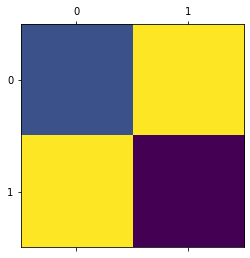

In [228]:
%matplotlib inline
plt.matshow(new_dm_table[-2:,-2:])

In [116]:
validation_results = []
for kk in range(3,50):
    classifier = KNeighborsClassifier(kk,metric='precomputed',weights='distance')
    classifier.fit(expt3_dmat[np.ix_(train_idxs, train_idxs)],np.array(labels)[train_idxs])
    class_preds = classifier.predict(expt3_dmat[np.ix_(valid_idxs, train_idxs)])
    acc_array = class_preds == np.array(labels)[valid_idxs]
    validation_results.append((kk, np.mean(acc_array)))
    
expt3_validation_results = validation_results    

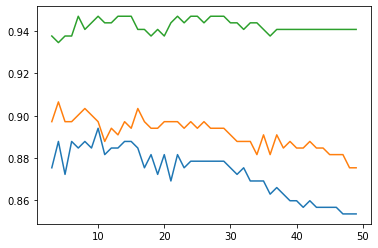

In [117]:
%matplotlib inline
plt.plot(*np.array(expt1_validation_results).T)
plt.plot(*np.array(expt2_validation_results).T)
plt.plot(*np.array(expt3_validation_results).T)

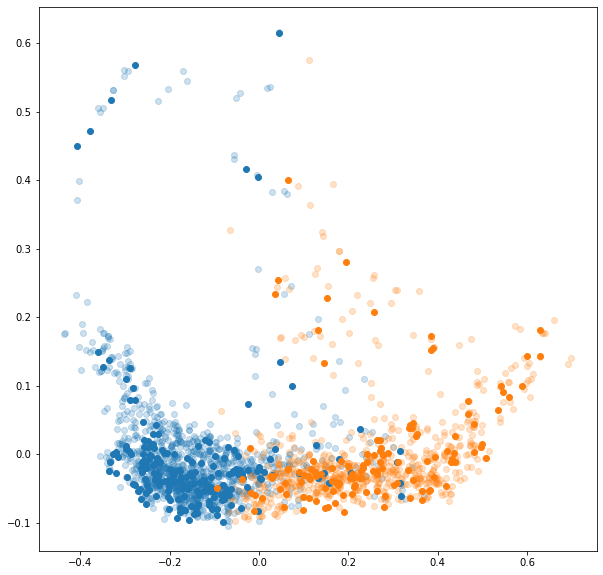

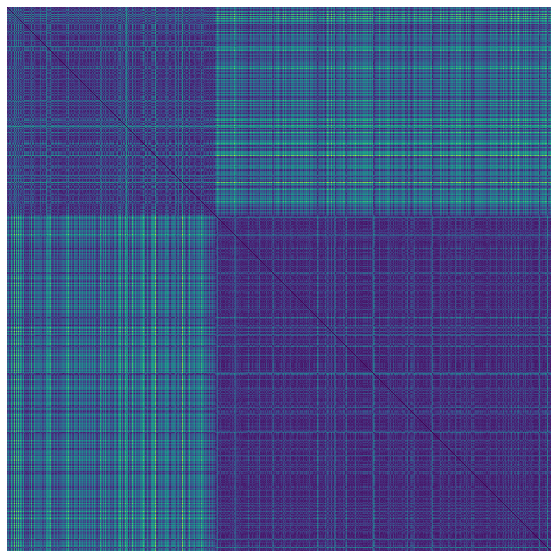

In [118]:
embedder = Isomap(n_neighbors=10, n_components=2,metric='precomputed')
mds_plot(embedder, expt3_dmat, train_idxs, valid_idxs)
dist_mat_plot(expt3_dmat, train_idxs, valid_idxs)

Experiment 4 - replacing the Gaussian Kernel with an arbitrary function parametrized by an ANN.

In [328]:
if DATASET == 'morpho':
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-2,2,8))))
    sigma1 = torch.nn.Parameter(torch.Tensor([.01]))
    sigma2 = torch.nn.Parameter(torch.Tensor([1.0/120.00]))
else:
    sigma = .01
    tp = torch.nn.Parameter(torch.Tensor(np.exp(np.linspace(-3,3,8))))

eweights = torch.nn.Parameter(torch.ones(GR_SIZE[0]))



In [423]:
tempSmallNet = smallNet

In [424]:
smallNet = torch.nn.Sequential(
    SparseActivation(torch.nn.BatchNorm1d(3)),
    SparseLinear(GR_SIZE[-1],128),
    SparseActivation(torch.nn.SiLU()),
    SparseLinear(128,32),
    SparseActivation(torch.nn.SiLU()),
    SparseLinear(32,32),
    SparseActivation(torch.nn.SiLU()),
    SparseLinear(32,32),
    SparseActivation(torch.nn.SiLU()),
    SparseLinear(32,32),
    SparseActivation(torch.nn.SiLU()),
    SparseLinear(32,1)
).cuda()

In [330]:
if DATASET == 'morpho':
    optimizer = optim.Adam([tp,sigma1,sigma2,eweights]+list(smallNet.parameters()), lr=0.001)

In [331]:
torch.cuda.empty_cache()

In [332]:
def laplModelForward(batchA):
    net_adj = torch.abs(torch.sparse.sum(smallNet(batchA),dim=-1).to_dense())
    part1 = batchA.to_dense()[:,:,:,-2]
    part2 = batchA.to_dense()[:,:,:,-1]
    all_adj = net_adj * (part2*torch.abs(sigma2.cuda())) * torch.exp(-.5*torch.pow(part1,2.0)*torch.abs(sigma1.cuda()))

    
    #print(all_adj.shape)
    #print(all_adj.shape)
    all_adj = all_adj
    
    dd = torch.abs(all_adj)
    dd = .5*(dd + torch.transpose(dd,-1,-2))
    dsum = dd.sum(-1)
    
    final_mm = all_adj - torch.diag_embed(dsum)
    return final_mm

def eigenModelForward(batchA):
    final_mm = laplModelForward(batchA)
    raw_eigs = torch.symeig(final_mm,eigenvectors=True)[0].clone()
    return raw_eigs
    #eigex = torch.exp(tt*raw_eigs)*new_weights
    #return eigex

In [333]:
train_dataset = TensorDataset( torch.stack([adj_sparse[i] for i in train_idxs]), label_tensor[train_idxs] )
train_loader = DataLoader(train_dataset, shuffle=True,batch_size= 256,drop_last=False)

valid_dataset = TensorDataset( torch.stack([aa1[i] for i in valid_idxs]), label_tensor[valid_idxs] )
valid_loader = DataLoader(valid_dataset, shuffle=False,batch_size= 32)

In [334]:
(np.max(np.diag(new_dm_table)),
np.min(new_dm_table + 1e12*np.eye(len(unique_labels))))

(0.3953299968065924, 0.05900518408437309)

For contrastive loss, we need upper and lower margins.

We'll establish these so that the lower margin is less than, but close to, the smallest within-category distance from Experiment 1. The upper margin will be more than, but close to, the biggest 

In [335]:
if DATASET == 'morpho':
    upper_margin = .33
    lower_margin = 0.001
else:
    lower_margin = .5
    upper_margin = 1.33

We can get an idea of whether the learing process is going well by comparing contrastive loss with these values to contrastive loss on the original distance matrix.

In [336]:
all_labels = np.array(labels)[train_idxs].reshape(-1,1)
dist_mat_label = torch.Tensor(np.sign(cdist(all_labels, all_labels)))
dist_mat_batch = torch.Tensor(expt2_dmat[np.ix_(train_idxs,train_idxs)])
loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
loss = torch.pow(loss_full,2.0).mean()
print(loss)

NameError: name 'expt2_dmat' is not defined

In [254]:
torch.__version__

'1.8.0'

In [337]:
sigma1, sigma2, tp

(Parameter containing:
 tensor([0.0100], requires_grad=True),
 Parameter containing:
 tensor([0.0083], requires_grad=True),
 Parameter containing:
 tensor([0.1353, 0.2397, 0.4244, 0.7515, 1.3307, 2.3564, 4.1727, 7.3891],
        requires_grad=True))

In [338]:
for k in range(600):
    total_loss = 0
    total_used = 0
    for ii, batch in enumerate(train_loader):
        optimizer.zero_grad()
        batchA, batchL = batch
        #print(batchA)
        batchT = batchA.float().cuda()
        batchTL = batchL.float().cuda()
        ft = eigenModelForward(batchT)
        
        
        tt = torch.abs(tp).cuda()
        new_weights = (GR_SIZE[0]*torch.nn.functional.softmax(eweights,dim=0).reshape(1,GR_SIZE[0])).cuda()
        
        dmats = []
        for tidx in range(tp.shape[0]):
            eee1pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            eee2pr = torch.exp(ft*torch.abs(tp[tidx]))*new_weights
            dmat = torch.cdist(eee1pr,eee2pr)
            dmats.append(dmat)
            
        dist_mat_batch = torch.stack(dmats).max(0)[0]
        dist_mat_label = torch.sign(torch.cdist(batchTL.unsqueeze(-1),batchTL.unsqueeze(-1)))
        
        #print(dist_mat_batch)
        loss_full = torch.multiply(dist_mat_label, torch.nn.functional.relu(upper_margin - dist_mat_batch)) +\
                torch.multiply(1-dist_mat_label, torch.nn.functional.relu(dist_mat_batch - lower_margin))
        #print(loss_full)
        loss = torch.pow(loss_full,2.0).sum()
        #print(loss_full.max())
        total_loss += loss.detach()
        used_batch = batch[0].shape[0]
        total_used += used_batch * used_batch
        #print(used_batch)
        loss = loss * (1.0/used_batch) * (1.0/used_batch)  
        loss.backward()
        optimizer.step()
      
    print(k, (total_loss/total_used).detach().cpu().numpy())

0 0.044574335
1 0.039164726
2 0.032940783
3 0.032518912
4 0.031429686
5 0.03085695
6 0.03056531
7 0.029944858
8 0.029789861
9 0.030476794
10 0.030056966
11 0.029612582
12 0.029915035
13 0.029432813
14 0.029560158
15 0.028760247
16 0.027091367
17 0.02608125
18 0.025401862
19 0.025137234
20 0.025008094
21 0.024523176
22 0.024633018
23 0.024053518
24 0.024194565
25 0.024864193
26 0.02384905
27 0.023860091
28 0.02302732
29 0.022531023
30 0.022218918
31 0.021466231
32 0.021136183
33 0.02119492
34 0.020144772
35 0.019693406
36 0.019725228
37 0.019243622
38 0.019094342
39 0.01918316
40 0.019236274
41 0.019161593
42 0.018880747
43 0.019012636
44 0.018963499
45 0.019053133
46 0.018800348
47 0.018896673
48 0.01898114
49 0.01878238
50 0.01877276
51 0.018763496
52 0.018742558
53 0.018795572
54 0.018637307
55 0.018777
56 0.018709227
57 0.01852175
58 0.018552827
59 0.018546829
60 0.01847986
61 0.018449077
62 0.018364567
63 0.018352624
64 0.018360602
65 0.018312141
66 0.018753767
67 0.018761236
68 0.

In [339]:
tp, eweights

(Parameter containing:
 tensor([0.1355, 0.2398, 0.4247, 0.7527, 1.3325, 2.4122, 4.0907, 7.3738],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.4969,  0.5605,  0.9130,  1.3827,  1.4411,  2.1351,  2.4791,  2.5257,
          2.5832,  2.5257,  2.5583,  2.5476,  2.5577,  2.2828,  2.0017,  2.0364,
          2.0265,  1.7957,  1.2758,  0.7286,  0.4068,  0.2350,  0.0829, -0.0133,
          0.0121,  0.0236, -0.0089, -0.0395, -0.0271, -0.0581, -0.0927, -0.1251,
         -0.1433, -0.1808, -0.1982, -0.2077, -0.1925, -0.1938, -0.1825, -0.1845,
         -0.1883, -0.1565, -0.1394, -0.1387, -0.1290, -0.1299, -0.1238, -0.1384,
         -0.1199, -0.1016, -0.0281,  0.0269,  0.0666,  0.0574,  0.0851,  0.1801,
          0.3938,  0.4048,  0.3545,  0.6572,  0.5799,  1.0245,  1.0039,  1.1767],
        requires_grad=True))

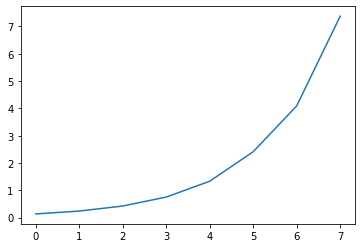

In [340]:
plt.plot(tp.detach().numpy())

In [341]:
expt4_dmat = np.zeros((len(adj_sparse),len(adj_sparse)))

In [342]:
with torch.no_grad():
    efts = torch.cat(
        [eigenModelForward(torch.stack([adj_sparse[i] for i in  index_batches[i1]]).float().cuda()).cpu()
         for i1 in range(len(index_batches))]
    ) 

    for i1 in range(len(index_batches)):
        print(i1)
        for i2 in range(i1,len(index_batches)):
            idxs1 = index_batches[i1]
            idxs2 = index_batches[i2]
            fts1 = efts[idxs1,:].cuda()#eigenModelrForward(torch.stack([adj_sparse[i] for i in idxs1]).float().cuda())
            fts2 = efts[idxs2,:].cuda()#eigenModelForward(torch.stack([adj_sparse[i] for i in idxs2]).float().cuda())

            dmats = []
            for tidx in range(tp.shape[0]):
                eee1pr = torch.exp(fts1*torch.abs(tp[tidx]))*new_weights
                eee2pr = torch.exp(fts2*torch.abs(tp[tidx]))*new_weights
                dmat = torch.cdist(eee1pr,eee2pr)
                dmats.append(dmat)

            expt4_dmat[np.ix_(idxs1, idxs2)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy()
            expt4_dmat[np.ix_(idxs2, idxs1)] = torch.stack(dmats).max(0)[0].cpu().detach().numpy().T        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [343]:
del efts

In [344]:
K = len(unique_labels)
new_dm_table = np.zeros((K,K))

subarrs = [expt4_dmat[label_arr==i,:] for i in range(K)]
subarrs = [[subarrs[i][:,label_arr==j]for j in range(K)] for i in range(K)]

for i in range(K):
    for j in range(K):
        new_dm_table[i,j] = subarrs[i][j].mean()

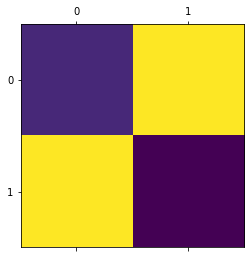

In [345]:
%matplotlib inline
plt.matshow(new_dm_table[-2:,-2:])

In [346]:
validation_results = []
for kk in range(3,50):
    classifier = KNeighborsClassifier(kk,metric='precomputed',weights='distance')
    classifier.fit(expt4_dmat[np.ix_(train_idxs, train_idxs)],np.array(labels)[train_idxs])
    class_preds = classifier.predict(expt4_dmat[np.ix_(valid_idxs, train_idxs)])
    acc_array = class_preds == np.array(labels)[valid_idxs]
    validation_results.append((kk, np.mean(acc_array)))
    
expt4_validation_results = validation_results    

In [374]:
print(
    np.max(expt1_validation_results,axis=0),
    np.max(expt2_validation_results,axis=0),
    np.max(expt3_validation_results,axis=0),
    np.max(expt4_validation_results,axis=0)
)

[49.        0.894081] [49.          0.90654206] [49.         0.9470405] [49.          0.99065421]


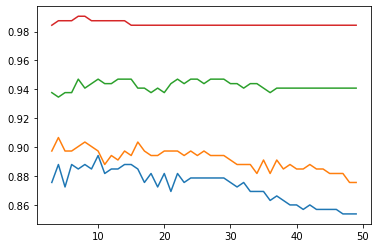

In [347]:
%matplotlib inline
plt.plot(*np.array(expt1_validation_results).T)
plt.plot(*np.array(expt2_validation_results).T)
plt.plot(*np.array(expt3_validation_results).T)
plt.plot(*np.array(expt4_validation_results).T)

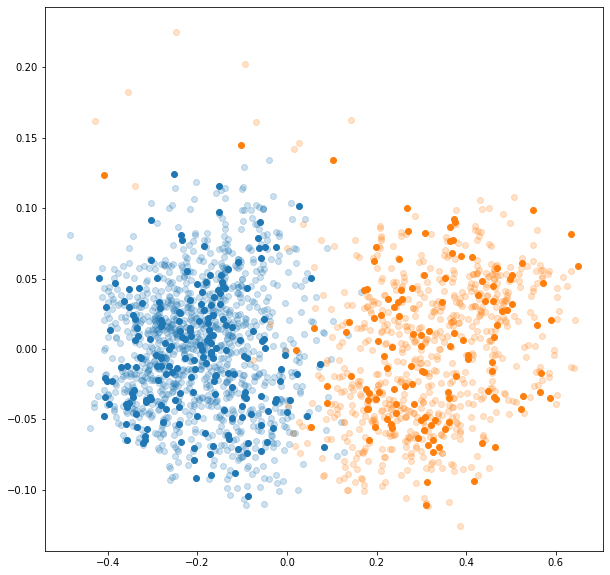

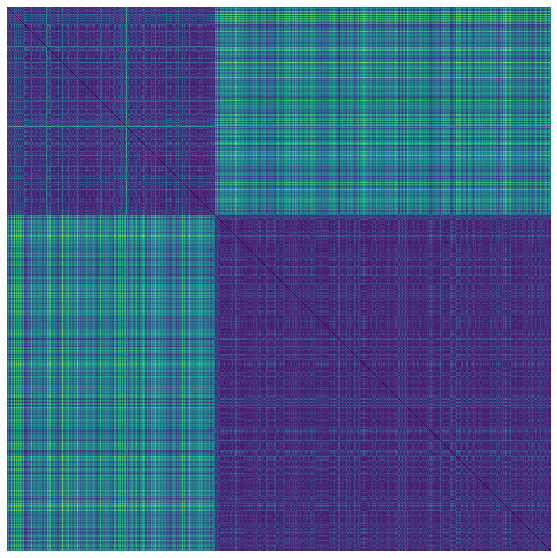

In [348]:
embedder = Isomap(n_neighbors=15, n_components=2,metric='precomputed')
mds_plot(embedder, expt4_dmat, train_idxs, valid_idxs)
dist_mat_plot(expt4_dmat, train_idxs, valid_idxs)

In [349]:
wt_idxs = np.argsort(new_dm_table[-1,:])
trm_idxs = np.argsort(new_dm_table[-2,:])
wt_to_plot = wt_idxs[:np.where(wt_idxs==WID_IDX)[0][0]]
trm_to_plot = trm_idxs[:np.where(trm_idxs==TRM_IDX)[0][0]]

In [350]:
viz_train_idxs = train_idxs[np.any(np.equal(label_arr[train_idxs].reshape(-1,1),np.array(list(trm_to_plot)+list(wt_to_plot)+[WID_IDX,TRM_IDX])),axis=-1)]
isoviz_train_idxs = train_idxs[np.any(np.equal(label_arr[train_idxs].reshape(-1,1),np.array([WID_IDX,TRM_IDX])),axis=-1)]
viz_valid_idxs = valid_idxs[np.any(np.equal(label_arr[valid_idxs].reshape(-1,1),np.array(list(trm_to_plot)+list(wt_to_plot)+[WID_IDX,TRM_IDX])),axis=-1)]
viz_sim_idxs = sim_idxs[np.any(np.equal(label_arr[sim_idxs].reshape(-1,1),np.array(list(trm_to_plot)+list(wt_to_plot)+[WID_IDX,TRM_IDX])),axis=-1)]

In [366]:
%matplotlib inline
THE_DMAT = expt4_dmat

#sclr = StandardScaler()
pca = Isomap(n_neighbors=15, n_components=2,metric='precomputed')

Xpr = pca.fit_transform(
        (
            THE_DMAT[np.ix_(viz_train_idxs, viz_train_idxs)]
        )
    )
Xtrain = pca.transform((THE_DMAT[np.ix_(viz_train_idxs, viz_train_idxs)]))
Xvalid = pca.transform((THE_DMAT[np.ix_(viz_valid_idxs, viz_train_idxs)]))
Xsim = pca.transform((THE_DMAT[np.ix_(viz_sim_idxs, viz_train_idxs)]))
 

In [367]:
viz_train_labels = label_arr[viz_train_idxs]
viz_valid_labels = label_arr[viz_valid_idxs]
viz_sim_labels = label_arr[viz_sim_idxs]

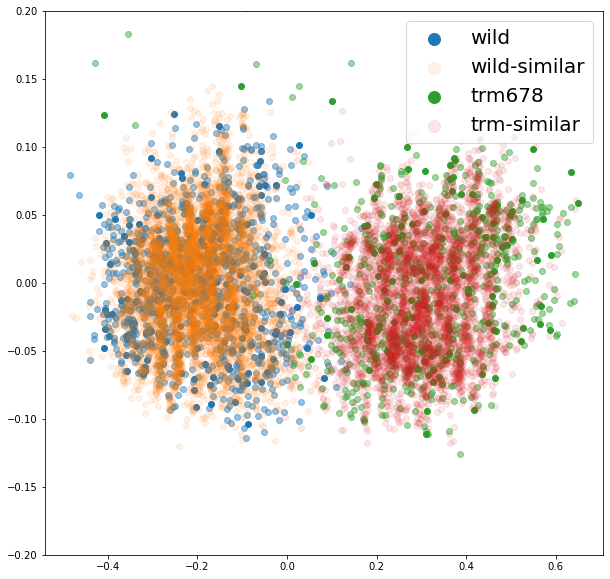

In [368]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

arts = []


ax.scatter(*Xtrain[viz_train_labels == WID_IDX ].T, c= 'C0', alpha=.45)
arts.append(ax.scatter(*Xvalid[viz_valid_labels == WID_IDX ].T, c= 'C0', alpha=1.0))
    
for cidx,i in enumerate(list(wt_to_plot)):
    newart=ax.scatter(*Xsim[viz_sim_labels == i ].T, c= 'C1', alpha=.1)

arts.append(newart)    

ax.scatter(*Xtrain[viz_train_labels == TRM_IDX ].T, c= 'C2', alpha=.45)
arts.append(ax.scatter(*Xvalid[viz_valid_labels == TRM_IDX ].T, c= 'C2', alpha=1.0))
    
for cidx,i in enumerate(list(trm_to_plot)):
    newart=ax.scatter(*Xsim[viz_sim_labels == i ].T, c= 'C3', alpha=.1)

arts.append(newart)

#for cidx,i in enumerate(list(far_idxs)[::10]):
#    ax.scatter(*Xtrain[np.array(labels)[train_idxs] == i ].T, c= 'C4', alpha=.225)
#    newart = ax.scatter(*Xvalid[np.array(labels)[valid_idxs] == i ].T, c= 'C4', alpha=.85)

#arts.append(newart)

ax.set_ylim(-.2,0.2)
ax.legend(arts,
          ["wild","wild-similar","trm678","trm-similar"],
          fontsize=20,
          markerscale = 2.0)
fig.savefig(DATASET+"_embedding_e1.png",dpi=600,
               transparent=True,
               bbox_inches='tight') 

In [354]:
def label_to_vec(vec):
    i,j,k,l = [int(item.replace('s','')) for item in vec.split("_")]
    return ([.1,.3,1.0,3.0][i],[.1,.3,.6][j],[0.0,.00001,.00003,.0001][k],[0.0,.01,.03,.1,.5,1.0][l])

In [355]:
def nearest_param_vec(idxsss):
    return label_to_vec(list(filter(lambda x: x!='wt' and x!='trm',np.array(unique_labels)[label_arr[np.argsort(expt4_dmat[idxsss])[:100]]]))[0])

In [356]:
def nearest_param_consensus(idxsss):
    ev = list(filter(lambda x: x!='wt' and x!='trm',np.array(unique_labels)[label_arr[np.argsort(expt4_dmat[idxsss])[:300]]]))[:30]
    return np.mean([label_to_vec(ii) for ii in ev],axis=0)

In [357]:
nearest_params = np.array([nearest_param_vec(ii) for ii in viz_train_idxs])

In [358]:
nearest_param_consen = np.array([nearest_param_consensus(ii) for ii in viz_train_idxs])

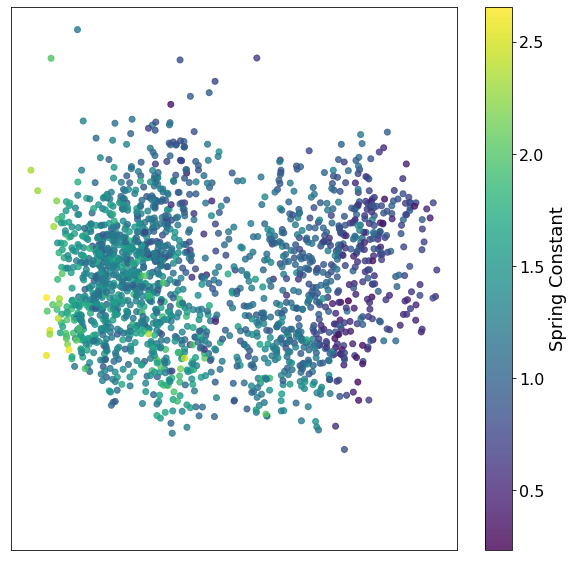

In [372]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

arts = []

param_idx=0

the_plotted_array = np.concatenate([
    Xtrain[viz_train_labels == WID_IDX ],
    Xtrain[viz_train_labels == TRM_IDX ]
])
the_color_array = np.concatenate(
   [nearest_param_consen[viz_train_labels == WID_IDX],
    nearest_param_consen[viz_train_labels == TRM_IDX]
   ]
)[:,param_idx]

a1=ax.scatter(*the_plotted_array.T, c=the_color_array , alpha=.8)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_ylim(-.2,0.2)
cbar = fig.colorbar(a1)
cbar.set_label(['Spring Constant', 'Vertex Avoid', 'Random Division Rate', 'Random Division Direction Rate'][param_idx],size=18)
cbar.ax.tick_params(labelsize=16)

In [515]:
def graph_plot_from_idx(IDX,EIGENWEIGH=torch.ones_like(nwcopy)):
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    the_lapl= laplModelForward(
        torch.unsqueeze(
            adj_sparse[IDX]
        ,0).float().cuda())
    the_adj = the_lapl.detach().cpu().numpy()[0]
    EEs, UUs = torch.symeig(LL, eigenvectors=True)
    
    the_adj = np.multiply(the_adj,UUs[0].matmul(torch.diag(torch.mul(EIGENWEIGH,EEs[0])).T).matmul(UUs[0].T).detach().numpy())
    the_adj -= np.diagflat(np.diag(the_adj))
    vpos = fname_to_vertdata(fnames[IDX])
    vpos_dict = {i:tuple(vpos[i]) for i in range(vpos.shape[0])}
    G = nx.from_numpy_array(the_adj)
    edges = G.edges()
    edge_colors = [G[u][v]['weight'] for u,v in edges]
    nx.draw(G,pos=vpos_dict,edge_color=edge_colors,node_size=0,width=6,ax=ax,edge_vmin=0,edge_vmax=.0016)

In [521]:
(label_arr[all_idxs] == TRM_IDX).sum(),(label_arr[all_idxs] == WID_IDX).sum()

(815, 1316)

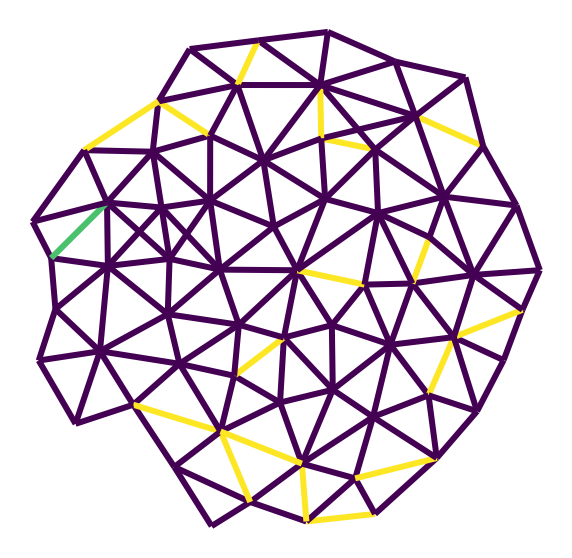

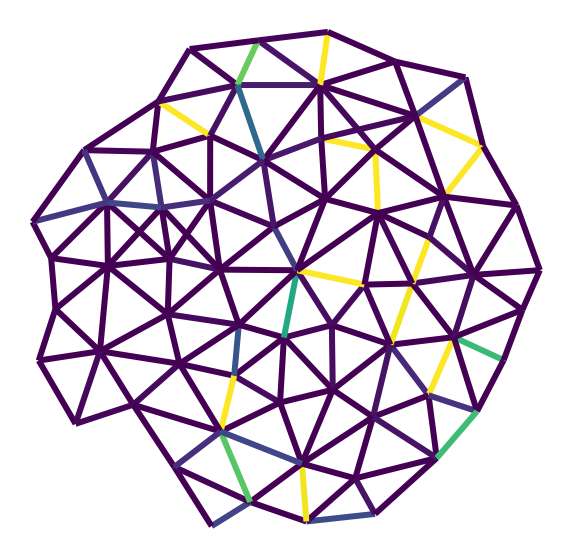

In [516]:
smallNet = rawSmallNet
graph_plot_from_idx(train_idxs[-1])
smallNet = tempSmallNet
graph_plot_from_idx(train_idxs[-1],EIGENWEIGH=1.0/nwcopy)

In [490]:
LL = laplModelForward(
        torch.stack(
            [adj_sparse[train_idxs[0]],
             adj_sparse[train_idxs[1]],
             adj_sparse[train_idxs[-2]],
             adj_sparse[train_idxs[-1]]]
        ).float().cuda()).detach().cpu()
EEs, UUs = torch.symeig(LL, eigenvectors=True)

In [491]:
torch.diag(torch.mul(1.0/new_weights.clone().cpu().T,EEs[0]))

tensor([-3.3410e+00, -3.1157e+00, -2.1424e+00, -1.3009e+00, -1.1105e+00,
        -5.4656e-01, -3.7880e-01, -3.5568e-01, -3.2833e-01, -3.3999e-01,
        -3.2212e-01, -3.2116e-01, -3.1402e-01, -4.0727e-01, -5.3526e-01,
        -5.0060e-01, -5.0335e-01, -6.0200e-01, -9.9132e-01, -1.6558e+00,
        -2.2684e+00, -2.6762e+00, -2.9756e+00, -3.1869e+00, -3.0166e+00,
        -2.9037e+00, -2.9408e+00, -2.9520e+00, -2.8281e+00, -2.9101e+00,
        -2.9294e+00, -2.9049e+00, -2.8518e+00, -2.8470e+00, -2.8392e+00,
        -2.7578e+00, -2.6720e+00, -2.5852e+00, -2.3662e+00, -2.2472e+00,
        -2.1437e+00, -2.0266e+00, -1.8982e+00, -1.8398e+00, -1.6362e+00,
        -1.5919e+00, -1.4747e+00, -1.4185e+00, -1.3624e+00, -1.2640e+00,
        -1.0502e+00, -8.6907e-01, -7.8206e-01, -7.3702e-01, -6.5887e-01,
        -5.0100e-01, -3.5467e-01, -2.9895e-01, -2.7033e-01, -1.4846e-01,
        -1.4828e-01, -4.3923e-02, -4.1689e-02,  8.8180e-08],
       grad_fn=<DiagBackward>)

In [492]:
UUs[0].matmul(torch.diag(torch.mul(nwcopy,EEs[0])).T).matmul(UUs[0].T) 

tensor([[-3.1818e+00, -1.3920e-02, -2.6642e-01,  ...,  1.3320e+00,
          1.4853e-02, -2.4145e-01],
        [-1.3920e-02, -2.1688e+00,  3.1585e-03,  ..., -3.6956e-03,
          8.9867e-01,  9.8787e-03],
        [-2.6642e-01,  3.1585e-03, -5.3794e-01,  ...,  1.4297e-01,
          3.1503e-02, -1.0324e-02],
        ...,
        [ 1.3320e+00, -3.6956e-03,  1.4297e-01,  ..., -1.2319e+00,
          3.9908e-03,  1.0895e+00],
        [ 1.4853e-02,  8.9867e-01,  3.1503e-02,  ...,  3.9908e-03,
         -7.3723e-01, -8.7074e-03],
        [-2.4145e-01,  9.8788e-03, -1.0325e-02,  ...,  1.0895e+00,
         -8.7074e-03, -2.0909e+00]], grad_fn=<MmBackward>)

In [485]:
nwcopy = new_weights.clone()[0].cpu()
nwcopy.shape

torch.Size([64])

In [472]:
EEs[0].shape

torch.Size([64])

In [489]:
smallNet = rawSmallNet

In [451]:
smallNet = tempSmallNet

289


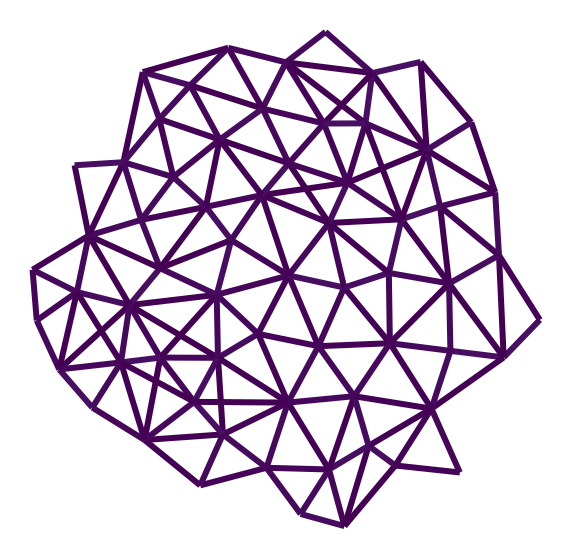

In [448]:
iii = 2
graph_plot_from_idx(train_idxs[iii])
print(labels[iii])

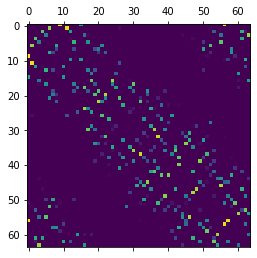

In [390]:
plt.matshow(the_adj)